## Configuracion de Entorno

In [60]:
import os

# Si estás en Jupyter Notebook, anclás a una ruta conocida o fija:
project_root = r"C:\Users\juanm\GitHub\UA_MDM_Labo2_G9"  # ⚠️ Personalizá esto

# Alternativa: usar una carpeta conocida dentro del proyecto
# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Menos frágil

# Rutas de trabajo
workDir = os.path.join(project_root, "work")
optunaArtifactDir = os.path.join(workDir, "optuna_artifacts")
optunaTempDir = os.path.join(workDir, "optuna_temp_artifacts")

# Crear carpetas si no existen
os.makedirs(optunaArtifactDir, exist_ok=True)
os.makedirs(optunaTempDir, exist_ok=True)

# Cambiar al directorio de trabajo solo si es necesario
if os.getcwd() != workDir:
    os.chdir(workDir)

print("Directorio actual:", os.getcwd())


Directorio actual: C:\Users\juanm\GitHub\UA_MDM_Labo2_G9\work


In [61]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Modelado: Gradient Boosting
import lightgbm as lgb

# Sklearn: splits, métricas y utilidades
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Visualización
import matplotlib.pyplot as plt  # Usar junto con seaborn o plotly si es necesario
import plotly.express as px      # Corrección: no usar `from plotly import express as px`

# Optuna para optimización de hiperparámetros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

# Utilidades propias
from utiles import plot_confusion_matrix

# Guardado de objetos
from joblib import dump, load

# Sistema
import os

In [62]:
import os

# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Datos de razas 
PATH_TO_BREED_LABELS = os.path.join(BASE_DIR, "modelo/data/petfinder-adoption-prediction/BreedLabels.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

## Descripcion Feature Engineering

### 🔹 1. **Transformaciones directas útiles**
Variables que ya estaban en los datos, pero necesitaban reformularse para ser más informativas o manejables.

| Variable            | Qué hace                                                   | Por qué ayuda                                                  |
|---------------------|------------------------------------------------------------|-----------------------------------------------------------------|
| `HasName`           | Indica si el animal tiene nombre                           | Un animal con nombre puede verse más cercano o adoptable       |
| `HasPhoto`          | Indica si tiene al menos una foto                          | Las fotos mejoran visibilidad y atracción                      |
| `HasVideo`          | Indica si tiene video cargado                              | Videos pueden generar más confianza y detalle visual           |
| `HasDescription`    | Indica si hay texto descriptivo                            | Sin descripción puede percibirse como menos confiable          |
| `MixBreed`          | Indica si es de raza mixta (`Breed2 ≠ 0`)                  | Las razas puras pueden ser preferidas o evitadas               |
| `TotalColors`       | Cuántos colores distintos tiene el animal                  | Puede influir en la percepción estética                        |
| `Fee_log`           | Log del precio de adopción                                 | Reduce el impacto de valores extremos                          |
| `DescLength`        | Longitud de la descripción del anuncio                     | Anuncios más detallados pueden atraer más                      |
| `IsFree`            | Indica si el animal es gratuito (`Fee == 0`)               | El costo influye en la decisión de adoptar                     |

**Objetivo**: facilitar al modelo patrones lineales y normalizados.

---

### 🔹 2. **Reagrupaciones o codificaciones útiles**
Transforman datos categóricos o numéricos en formas que capturan relaciones importantes.

| Variable             | Qué hace                                                        | Por qué ayuda                                                   |
|----------------------|------------------------------------------------------------------|------------------------------------------------------------------|
| `AgeBins`            | Categorización de edades (ej: cachorro, adulto)                 | Refleja fases vitales con diferentes tasas de adopción           |
| `Type_Breed_Combo`   | Combina tipo de animal y raza principal                         | Algunas combinaciones son más atractivas para adoptantes         |
| `RescuerCount`       | Cuántos animales publicó ese rescatista                         | Un rescatista muy activo puede tener diferente tasa de éxito     |
| `DescriptionType`    | Clasifica la longitud de la descripción (ninguna, corta, media, larga) | Permite distinguir esfuerzo y detalle en el anuncio         |

**Objetivo**: capturar efectos de grupos que el modelo pueda aprender más fácilmente.

---

### 🔹 3. **Interacciones entre variables**
Estas variables combinan otras para capturar relaciones no lineales o más profundas.

| Variable               | Qué hace                                                             | Por qué ayuda                                                        |
|------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|
| `Fee_per_Pet`          | Distribuye el costo entre la cantidad de animales                   | Costo individual más preciso para grupos de mascotas                 |
| `Photo_per_Pet`        | Normaliza la cantidad de fotos según cantidad                       | Más fotos por mascota puede reflejar mayor dedicación                |
| `Age_Fee_Ratio`        | Relación entre edad y costo                                          | Puede capturar si hay sobreprecio para ciertas edades                |
| `DescLength_per_Pet`   | Texto por animal (en caso de grupos)                                | Descripciones muy generales pueden indicar poca información útil     |

**Objetivo**: capturar relaciones más sutiles y específicas entre múltiples variables.

---

### 🔹 4. **Perfiles ideales y esfuerzo del rescatista**
Condensan múltiples variables en indicadores que reflejan un “perfil atractivo” para adopción.

| Variable         | Qué hace                                                                 | Por qué ayuda                                                                 |
|------------------|--------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| `IsIdealDog`     | Indica si el perro cumple un perfil ideal de adopción                   | Resume características clave para adopción rápida (joven, saludable, gratuito, etc.) |
| `IsIdealCat`     | Idem, pero para gatos                                                    | Permite modelar adopción exitosa específica para gatos                       |

**Objetivo**: sintetizar múltiples condiciones de “adoptabilidad” que serían difíciles de capturar individualmente por el modelo.

## Feature Engineering

In [ ]:
import numpy as np
import pandas as pd

# Cargar el dataset
dataset = pd.read_csv(PATH_TO_TRAIN)

# 1. Tiene nombre
dataset['HasName'] = dataset['Name'].notnull().astype(int)

# 2. Tiene Foto
dataset['HasPhoto'] = (dataset['PhotoAmt'] > 0).astype(int)

# 3. Tiene Video
dataset['HasVideo'] = (dataset['VideoAmt'] > 0).astype(int)

# 4. Tiene Description
dataset['HasDescription'] = (dataset['Description'].notnull()).astype(int)

# 5. Es de raza mixta
# Cargar etiquetas de razas
breed_labels = pd.read_csv(PATH_TO_BREED_LABELS)

# Diccionario ID → Nombre de raza
id_to_breed = dict(zip(breed_labels['BreedID'], breed_labels['BreedName']))

# Crear una nueva columna con el nombre de Breed1
dataset['Breed1_name'] = dataset['Breed1'].map(id_to_breed)

# Ahora redefinimos MixBreed
dataset['MixBreed'] = (
    (dataset['Breed2'] != 0) |
    (dataset['Breed1_name'].str.contains('Mixed', case=False, na=False))
).astype(int)

# 6. Total de colores diferentes
dataset['TotalColors'] = dataset[['Color1', 'Color2', 'Color3']].ne(0).sum(axis=1)

# 7. Log de la tarifa (evita problemas con outliers)
dataset['Fee_log'] = np.log1p(dataset['Fee'])

# 8. Longitud de la descripción
dataset['DescLength'] = dataset['Description'].fillna('').apply(len)

# 9. Adopción gratuita
dataset['IsFree'] = (dataset['Fee'] == 0).astype(int)

# 10. Bin de edad (categórica ordinal)
dataset['AgeBins'] = pd.cut(dataset['Age'],
                            bins=[-1, 6, 12, 60, 120, np.inf],
                            labels=['Cachorro', 'Joven', 'Adulto', 'Mayor', 'Anciano'])

# 11. Combinación tipo-raza principal
dataset['Type_Breed_Combo'] = dataset['Type'].astype(str) + '_' + dataset['Breed1'].astype(str)

# 12. Cuántas mascotas publicó cada rescatista
rescuer_counts = dataset['RescuerID'].value_counts()
dataset['RescuerCount'] = dataset['RescuerID'].map(rescuer_counts)

# 13. Tarifa por mascota
dataset['Fee_per_Pet'] = dataset['Fee'] / dataset['Quantity'].replace(0, 1)

# 14. Fotos por mascota
dataset['Photo_per_Pet'] = dataset['PhotoAmt'] / dataset['Quantity'].replace(0, 1)

# 15. Relación edad/tarifa
dataset['Age_Fee_Ratio'] = dataset['Age'] / (dataset['Fee'] + 1)

# 16. Longitud descripción por mascota
dataset['DescLength_per_Pet'] = dataset['DescLength'] / dataset['Quantity'].replace(0, 1)

# 17. Categorización de longitud de descripción
dataset['DescriptionType'] = pd.cut(dataset['Description'].fillna('').apply(len),
                                    bins=[0, 5, 170, 3500, np.inf],
                                    labels=['Ninguna', 'Corta', 'Media', 'Larga'])

# 18. Perfil ideal de perro
dataset['IsIdealDog'] = (
    (dataset['Type'] == 1) &
    (dataset['MaturitySize'].isin([1, 2])) &
    (dataset['HasName'] == 1) &
    (dataset['Age'] > 0) & (dataset['Age'] < 24) &
    (dataset['Health'] == 1) &
    (dataset['Fee'] == 0) &
    (dataset['DescriptionType'].isin(['Corta', 'Media'])) &
    (dataset['MixBreed'] == 0) &
    (dataset['Quantity'] == 1) &
    (dataset['HasPhoto'] == 1) &
    (dataset['Vaccinated'] == 1) &
    (dataset['Dewormed'] == 1) &
    (dataset['Sterilized'] == 1)
).astype(int)

# 19. Perfil ideal de gato
dataset['IsIdealCat'] = (
    (dataset['Type'] == 2) &
    (dataset['MaturitySize'].isin([1, 2])) &
    (dataset['HasName'] == 1) &
    (dataset['Age'] > 0) & (dataset['Age'] < 24) &
    (dataset['Health'] == 1) &
    (dataset['Fee'] == 0) &
    (dataset['DescriptionType'].isin(['Corta', 'Media'])) &
    (dataset['MixBreed'] == 0) &
    (dataset['Quantity'] == 1) &
    (dataset['HasPhoto'] == 1) &
    (dataset['Vaccinated'] == 1) &
    (dataset['Dewormed'] == 1) &
    (dataset['Sterilized'] == 1)
).astype(int)

# Convertir columnas categóricas a tipo 'category' (compatible con LightGBM)
dataset['AgeBins'] = dataset['AgeBins'].astype('category')
dataset['Type_Breed_Combo'] = dataset['Type_Breed_Combo'].astype('category')
dataset['DescriptionType'] = dataset['DescriptionType'].astype('category')

# 20. Interacción Edad + Género
# Definimos grupos de edad
# def age_group(age):
#     if age < 12:
#         return 'young'    # menos de 1 año
#     elif age < 60:
#         return 'adult'    # entre 1 y 5 años
#     else:
#         return 'senior'   # más de 5 años

# dataset['Age_Group'] = dataset['Age'].apply(age_group)

# # Mapeamos el género (asumiendo Gender 1=Male, 2=Female)
# gender_map = {1: 'male', 2: 'female'}
# dataset['Gender_Label'] = dataset['Gender'].map(gender_map)

# # Creamos la variable combinada
# dataset['Age_Gender_Interaction'] = dataset['Age_Group'] + '_' + dataset['Gender_Label']

# Convertir Age_Gender_Interaction a tipo categorica para LightGBM
# dataset['Age_Gender_Interaction'] = dataset['Age_Gender_Interaction'].astype('category')

# 21. Longitud de la descripción por rescatista
dataset['DescLength_per_Rescuer'] = dataset['DescLength'] / dataset['RescuerCount'].replace(0, np.nan)

# dataset['DescLength_per_Age'] = np.where(dataset['Age'] == 0, 0, dataset['DescLength'] / dataset['Age'])

# 20. Longitud de la descripción por RescuerCount
# dataset['DescLength_per_Rescuer'] = np.where(dataset['DescLength'] == 0, 0, dataset['DescLength'] / dataset['RescuerCount'])

# Verificamos
nuevas_columnas = dataset.columns[-20:]
print("Nuevas columnas agregadas:")
for col in nuevas_columnas:
    print(f"- {col}")


Nuevas columnas agregadas:
- HasPhoto
- HasVideo
- HasDescription
- Breed1_name
- MixBreed
- TotalColors
- Fee_log
- DescLength
- IsFree
- AgeBins
- Type_Breed_Combo
- RescuerCount
- Fee_per_Pet
- Photo_per_Pet
- Age_Fee_Ratio
- DescLength_per_Pet
- DescriptionType
- IsIdealDog
- IsIdealCat
- DescLength_per_Rescuer


In [76]:
# Listado total de columnas
print("Listado completo de columnas:")
for i, col in enumerate(dataset.columns):
    print(f"{i:02d}: {col}")

Listado completo de columnas:
00: Type
01: Name
02: Age
03: Breed1
04: Breed2
05: Gender
06: Color1
07: Color2
08: Color3
09: MaturitySize
10: FurLength
11: Vaccinated
12: Dewormed
13: Sterilized
14: Health
15: Quantity
16: Fee
17: State
18: RescuerID
19: VideoAmt
20: Description
21: PetID
22: PhotoAmt
23: AdoptionSpeed
24: HasName
25: HasPhoto
26: HasVideo
27: HasDescription
28: Breed1_name
29: MixBreed
30: TotalColors
31: Fee_log
32: DescLength
33: IsFree
34: AgeBins
35: Type_Breed_Combo
36: RescuerCount
37: Fee_per_Pet
38: Photo_per_Pet
39: Age_Fee_Ratio
40: DescLength_per_Pet
41: DescriptionType
42: IsIdealDog
43: IsIdealCat
44: DescLength_per_Rescuer


In [77]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

#Lista de features numericas
numeric_feats

['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 'AdoptionSpeed',
 'HasName',
 'HasPhoto',
 'HasVideo',
 'HasDescription',
 'MixBreed',
 'TotalColors',
 'Fee_log',
 'DescLength',
 'IsFree',
 'AgeBins',
 'Type_Breed_Combo',
 'RescuerCount',
 'Fee_per_Pet',
 'Photo_per_Pet',
 'Age_Fee_Ratio',
 'DescLength_per_Pet',
 'DescriptionType',
 'IsIdealDog',
 'IsIdealCat',
 'DescLength_per_Rescuer']

In [78]:
#Defino features a usar
features = numeric_feats.copy()
label = 'AdoptionSpeed'

# Eliminamos 'AdoptionSpeed' si está
if 'AdoptionSpeed' in features:
    features.remove('AdoptionSpeed')

#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

print(features)

['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'HasName', 'HasPhoto', 'HasVideo', 'HasDescription', 'MixBreed', 'TotalColors', 'Fee_log', 'DescLength', 'IsFree', 'AgeBins', 'Type_Breed_Combo', 'RescuerCount', 'Fee_per_Pet', 'Photo_per_Pet', 'Age_Fee_Ratio', 'DescLength_per_Pet', 'DescriptionType', 'IsIdealDog', 'IsIdealCat', 'DescLength_per_Rescuer']


## Modelo con hiperparametros por default

In [ ]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model1 = lgb.train(lgb_params,
                      lgb_train_dataset)

In [ ]:
lgb_model1.predict(X_test).argmax(axis=1)

In [ ]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model1.predict(X_test).argmax(axis=1)

#Calculo el Kappa
print(cohen_kappa_score(y_test,y_pred, weights = 'quadratic'))

#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))

## Modelo con optimizacion de hiperparametros train/test

In [79]:
#Funcion que vamos a optimizar. Optuna requiere que usemos el objeto trial para generar los parametros a optimizar
def lgb_objective(trial):
    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Genero objeto dataset de entrenamiento
    lgb_train_dataset = lgb.Dataset(data=X_train,
                                    label=y_train)

    #ajuste de modelo
    lgb_model2 = lgb.train(lgb_params,
                        lgb_train_dataset)
    
    #Devuelvo el score en test
    return(cohen_kappa_score(y_test,lgb_model2.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

In [80]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass", #nombre del experimento
                            load_if_exists=True) #continuar si ya existe

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2025-04-27 14:54:10,553] Using an existing study with name '04 - LGB Multiclass' instead of creating a new one.
[I 2025-04-27 14:54:17,309] Trial 700 finished with value: 0.36282557516111325 and parameters: {'lambda_l1': 0.0017959083508874857, 'lambda_l2': 1.8686638437009995e-05, 'num_leaves': 256, 'feature_fraction': 0.6440889878748752, 'bagging_fraction': 0.793076852017205, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 578 with value: 0.3993619212329351.
[I 2025-04-27 14:54:23,284] Trial 701 finished with value: 0.36442800205034476 and parameters: {'lambda_l1': 0.0003765053095711509, 'lambda_l2': 1.2371551608779234e-06, 'num_leaves': 232, 'feature_fraction': 0.6536470993817711, 'bagging_fraction': 0.8450390088775387, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 578 with value: 0.3993619212329351.
[I 2025-04-27 14:54:26,655] Trial 702 finished with value: 0.36334044827565215 and parameters: {'lambda_l1': 0.006412829907913649, 'lambda_l2': 3.66764874195717

In [81]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 0.0006198324932249703,
 'lambda_l2': 0.0012410632276461278,
 'num_leaves': 243,
 'feature_fraction': 0.7415123631687672,
 'bagging_fraction': 0.802075350656355,
 'bagging_freq': 7,
 'min_child_samples': 7}

In [82]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique())} | study.best_params

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model2 = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
print(cohen_kappa_score(y_test,lgb_model2.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

display(plot_confusion_matrix(y_test,lgb_model2.predict(X_test).argmax(axis=1)))



0.3993619212329351


## Modelo con optimizacion de hiperparametros con 5 Fold Cross Validation

In [ ]:
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np
import os
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return (metric_name, value, is_higher_better)

def cv_es_lgb_objective(trial):
    
    # Inicio el store de artefactos (archivos) de Optuna
    artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

    # Hiperparámetros a optimizar
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_jobs': -1
    }
    
    scores_ensemble = np.zeros((len(y_test), len(y_train.unique())))
    score_folds = 0
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):

        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                     label=y_train.iloc[if_index],
                                     free_raw_data=False)
        
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                      label=y_train.iloc[oof_index],
                                      free_raw_data=False)
                
        lgb_model3 = lgb.train(
            lgb_params,
            lgb_if_dataset,
            valid_sets=lgb_oof_dataset,
            callbacks=[lgb.early_stopping(10, verbose=False)],
            feval=lgb_custom_metric_kappa
        )
        
        scores_ensemble += lgb_model3.predict(X_test)

        score_folds += cohen_kappa_score(
            y_train.iloc[oof_index],
            lgb_model3.predict(X_train.iloc[oof_index]).argmax(axis=1),
            weights='quadratic'
        ) / n_splits
    
    # Guardar predicciones sobre test
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p, :] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)

    # Uso keyword arguments en upload_artifact. Asociar las predicciones como artefacto.
    upload_artifact(
        study_or_trial=trial,
        file_path=predicted_filename,
        artifact_store=artifact_store
    )

    # Generar nombre de archivo (¡esto es un string, no lo pises!)
    cm_filename = os.path.join(PATH_TO_TEMP_FILES, f'cm_{trial.study.study_name}_{trial.number}.jpg')

    # Crear y guardar matriz de confusión
    cm = confusion_matrix(y_test, scores_ensemble.argmax(axis=1))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.savefig(cm_filename)
    plt.close()

    # Uso keyword arguments en upload_artifact. Asociar la imagen como artefacto
    upload_artifact(
        study_or_trial=trial,
        file_path=cm_filename,
        artifact_store=artifact_store
    )
    
    # Guardar el score en test como métrica auxiliar
    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    # Devuelvo el promedio de los scores del CV (objetivo a maximizar)
    return score_folds

In [ ]:
import optuna

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",
                            study_name="04 - LGB Multiclass CV",
                            load_if_exists = True)

#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

## LGBM Importance Futures

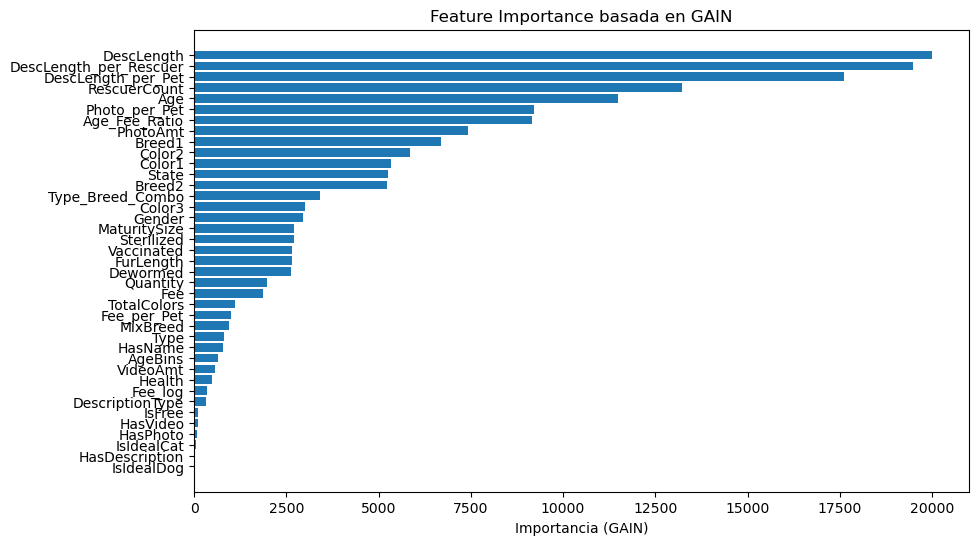

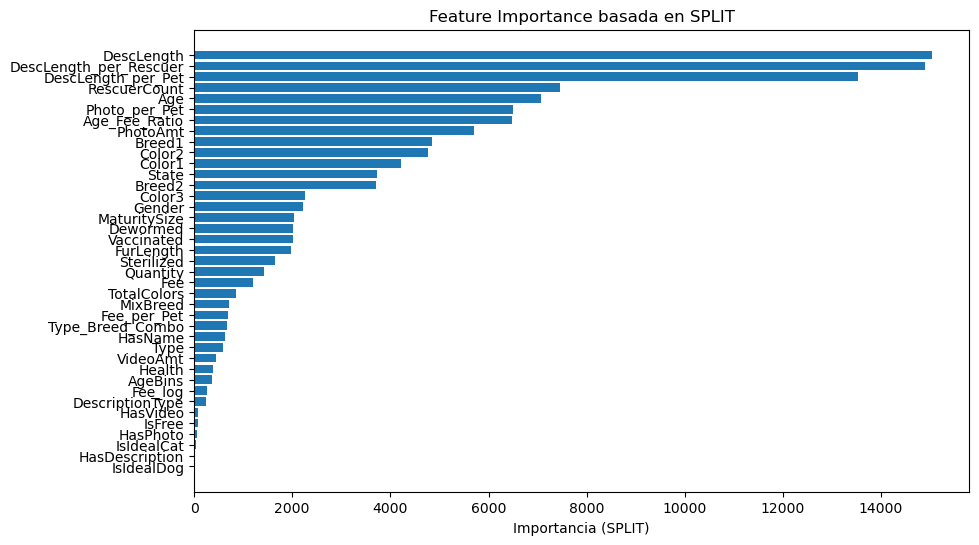

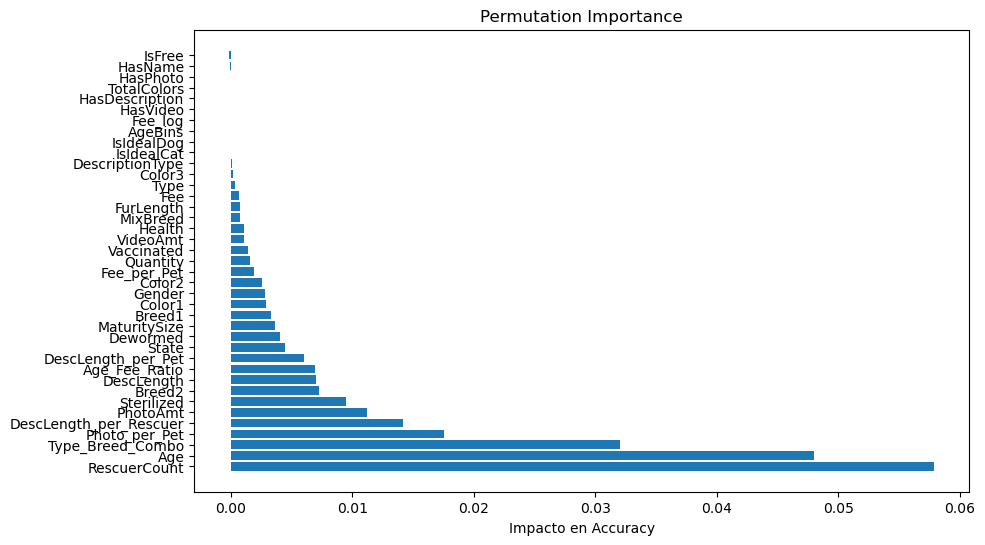

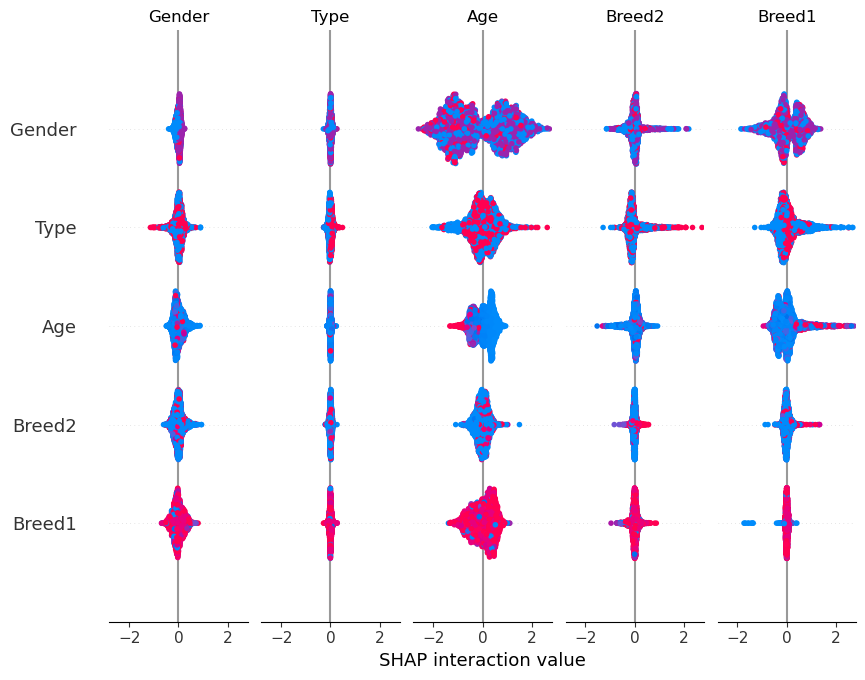

In [73]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

features = np.array(features)

# --------------------
# 1. Feature Importance basada en GAIN
# --------------------
importances_gain = lgb_model2.feature_importance(importance_type='gain')
sorted_idx_gain = importances_gain.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_gain], importances_gain[sorted_idx_gain])
plt.xlabel('Importancia (GAIN)')
plt.title('Feature Importance basada en GAIN')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 2. Feature Importance basada en SPLIT
# --------------------
importances_split = lgb_model2.feature_importance(importance_type='split')
sorted_idx_split = importances_split.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_split], importances_split[sorted_idx_split])
plt.xlabel('Importancia (SPLIT)')
plt.title('Feature Importance basada en SPLIT')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 3. Permutation Importance
# --------------------
# Para permutation necesitamos un modelo tipo sklearn, armamos uno rápido
model_sklearn = lgb.LGBMClassifier(boosting_type='gbdt')
model_sklearn.fit(X_train, y_train)

perm_result = permutation_importance(model_sklearn, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
sorted_idx_perm = perm_result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx_perm], perm_result.importances_mean[sorted_idx_perm])
plt.xlabel('Impacto en Accuracy')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

# --------------------
# 4. SHAP Values
# --------------------
explainer = shap.TreeExplainer(lgb_model2)
shap_values = explainer.shap_values(X_test)

# Graficar importancia promedio
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="dot")
